<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Unsupervised%20Learning/%ED%95%B8%EC%A6%88%EC%98%A8%20%EB%B9%84%EC%A7%80%EB%8F%84%20%ED%95%99%EC%8A%B5/Ch_10_RBM%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%B6%94%EC%B2%9C_%EC%8B%9C%EC%8A%A4%ED%85%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 생성적 비지도 학습 모델

* 원본 데이터에서 확률 분포를 학습하고 새로운 데이터를 추론하기 위해 사용

# 볼츠만 머신

* 제약이 없는 유형의 볼츠만 머신은 입력층과 하나 또는 여러 개의 은닉층이 있는 신경망으로 구성된다

* 신경망의 뉴런 또는 유닛은 훈련 중에 공급되는 데 데이터와 볼츠만 머신이 최소화하려는 비용 함수를 기반으로 활성화할지 여부에 확률적 결정을 내린다

* 이러한 훈련을 통해 데이터 존재하는 복잡하고 내재된 관계 및 패턴을 모델링 하는 데 도움이 되는 특징이 있다



# 제한된 볼츠만 머신

* 입력층과 단 하나의 은닉층을 가지고, 다른 층의 뉴련과는 연결되지만 동일한 계층 내 뉴련끼리는 연결되지 않도록 뉴런 간 연결을 제한한 방법

* 즉, 가시층 내 뉴런들 간 연결 및 은닉층 내 뉴련들 간 연결이 없다

# 추천 시스템

* 추천 시스템에는 협업 필터링 추천 시스템과 콘텐츠 기반 필터링 추천 시스템이라는 두 가지 주요 유형이 있다

* 협업 필터링

  - 사용자의 과거 행위와 해당 사용자와 유사한 다른 사용자의 행위를 기반으로 추천 시스템을 구축
  - 또한 사용자가 명확한 관심을 표현한 적이 없더라도 사용자가 관심을 가질 수 있는 아이템을 예측할 수 있다

* 콘텐츠 기반 필터링

  - 아이템의 고유한 속성을 학습해 유사한 속성을 가진 다른 아이템을 추천하는 것

# 협업 필터링

* 일반적으로 아이템의 고유한 속성을 학습하는 것은 어려운 작업이기 떄무에 콘텐츠 기반 필터링은 널리 사용하지 않는다

* 이보다 사용자 행동 및 선호도 정보를 많이 수집 및 분석하고 이를 기반으로 예측하는 것이 훨씬 쉽다

* 협업 필터링은 아이템 자체에 대한 속성 지식이 필요하지 않는다

* 오히려 협업 필터링은 과거에 동일한 사용자가 미래에도 동일할 것이고 사용자 선호도는 시간이 지남에 따라 안정적으로 유지된다고 가정한다

* 또한 협업 필터링은 명시적 데이터에 의존할 필요가 없다

* 오히려 사용자가 특정 아이템을 보거나 클릭하는 시간 및 빈도와 같은 암시적 데이터로 작동할 수  있다

* 그러나 협업 필터링도 어려운 점이 존재

  - 좋은 추천을 만들기 위해서는 사용자 데이터가 많이 필요하다
  - 계산이 매우 복잡하다
  - 데이터셋이 일반적으로 매우 희소하다

# Setting

## Library

In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

In [4]:
import lightgbm as lgb

In [70]:
import tensorflow.compat.v1 as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

# Load Data Set

## Google Drive Mount

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## load Rating Data Set

In [7]:
path_rating = '/content/drive/MyDrive/머신러닝 엔지니어링/핸즈온 비지도 학습/data/ml-20m/ratings.csv'

ratingDF = pd.read_csv(path_rating)

In [8]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


# Preprocessing

## 데이터 유형 변경

In [9]:
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

## 전체 데이터 셋에 대한 요약 통계

In [10]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


## 상위 1000개 영화 추출로 데이터 셋 크기 축소

In [11]:
movieIndex = ratingDF.groupby("movieId")\
             .count()\
             .sort_values(by="rating",
                          ascending=False)[0:1000].index

ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

## 사용자 1000명 샘플링으로 데이터 셋 크기 축소

In [12]:
userIndex = ratingDFX2.groupby("userId")\
            .count()\
            .sort_values(by="rating", ascending=False)\
            .sample(n=1000, random_state=2022).index

ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       91128
movieId      91128
rating       91128
timestamp    91128
dtype: int64

## 영화 ID 다시 인덱싱

In [13]:
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

,originalMovieId,newMovieId
0,203,1
1,318,2
2,356,3
3,508,4
4,527,5


## 사용자 ID 다시 인덱싱

In [14]:
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1
usersDF.head()

,originalUserId,newUserId
0,213,1
1,283,2
2,304,3
3,345,4
4,392,5


## 새롭게 병합된 데이터프레임 생성 

In [15]:
ratingDFX3 = ratingDFX3.merge(moviesDF,
                              left_on='movieId',
                              right_on='originalMovieId')

ratingDFX3.drop(labels='originalMovieId',
                axis=1,
                inplace=True)

ratingDFX3 = ratingDFX3.merge(usersDF,
                              left_on='userId',
                              right_on='originalUserId')

ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)

In [16]:
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,213,203,5.0,2013-11-16 11:26:56,1,1
1,213,318,5.0,2013-11-16 11:33:08,2,1
2,213,356,5.0,2013-11-16 11:43:00,3,1
3,213,508,5.0,2013-11-16 11:44:18,4,1
4,213,527,5.0,2013-11-16 11:33:14,5,1


## 축소된 데이터셋의 요약 통계 계산

In [17]:
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  91128
Average number of ratings per user:  91.128


## Split Train / Val / Test Set

In [18]:
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10,
                                   shuffle=True, 
                                   random_state=2022)

X_validation, X_test = train_test_split(X_test,
                                        test_size=0.50,
                                        shuffle=True,
                                        random_state=2022)

In [19]:
print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))

Size of train set:  82015
Size of validation set:  4556
Size of test set:  4557


# Modeling

## 훈련을 위한 평점 행렬 생성

* m x n 행렬 (m : 사용자 / n : 영화)

* 사용자가 극히 일부만 평가하기 때문에 이 행렬은 희소하게 채워진 행렬이 됨

In [28]:
ratings_train = np.zeros((n_users, n_movies))

for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [30]:
print(ratings_train.shape)
ratings_train

(1000, 1000)


array([[5. , 5. , 0. , ..., 0. , 0. , 0. ],
       [0. , 5. , 5. , ..., 0. , 0. , 0. ],
       [0. , 4.5, 5. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 5. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [31]:
# 훈련 평점 행렬 희소성 계산
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.20%


## 검증 & 테스트를 위한 평점 행렬 생성

In [32]:
# 검증을 위한 평점 행렬 생성
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [34]:
# 검증 평점 행렬의 희소성 계산
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.46%


In [33]:
# 테스트를 위한 평점 행렬 생성
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

## 단순 평균 평점 3.5로 예측 할당한 경우 베이스라인으로 MSE 계산

In [35]:
# 실제 평점 벡터
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [36]:
# 검증셋으로 평균 평점 3.5로 예측한 후 MSE 계산
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5

naive_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using naive prediction:', naive_prediction)

Mean squared error using naive prediction: 1.0267778753292363


## 사용자의 평균 평점 (사용자가 다른 모든 영화에 대해 평가한 평점의 평균값)을 기반으로 영화에 대한 사용자의 평점을 예측

In [37]:
ratings_validation_prediction = np.zeros((n_users, n_movies))

i = 0

for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] = np.mean(row[row>0])
    i += 1

pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()

user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.8513987038815439


## 행렬 인수분해

* 사용자-아이템 행렬을 두 개의 저차원 행렬의 곱으로 분해

* 사용자는 더 낮은 차원의 잠재 공간에 표현되며 아이템도 마찬가지이다

* 사용자-아이템 행렬을 사용자 m명과 아이템 n개가 있는 R이라고 가정

* 행렬 인수분해는 두 개의 저차원 행렬인 H와 W를 생성

  - H : m 사용자 * k 잠재 요인 행렬
  - W : k 잠재 요인 * n 아이템 행렬

* 평점은 행렬 곱셉에 의해 계산 : R = H * W

* 잠재 요인 k의 개수에 따라 모델의 수용량이 결정된다
  
  - k 값이 클수록 모델의 수용량이 커진다
  - k 값을 높이면 사용자에 대한 평정 예측의 개인화는 향상시킬 수 있지만 모델이 데이터를 과대적합하게 될 수 있다


### 잠재 요인이 1개일 때

* 입력은 사용자 임베딩을 위한 1차원 벡터와 영화 임베딩을 위한 1차원 벡터이다

* 하나의 잠재 공간에 이러한 입력 벡터를 임베딩하고, 이를 1차원 배열로 변환한다

* 출력 벡터 프로덕션을 생성하기 위해, 영화 벡터와 사용자 벡터의 내적을 구한다

In [38]:
n_latent_factors = 1

user_input = Input(shape=[1], name='user')

user_embedding = Embedding(input_dim=n_users + 1,
                           output_dim=n_latent_factors, 
                           name='user_embedding')(user_input)

user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)

movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)

model = Model(inputs=[user_input, movie_input], outputs=product)

In [39]:
model.compile('adam', 'mean_squared_error')

In [40]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100,
                    validation_data=([X_validation.newUserId,
                                      X_validation.newMovieId],
                                     X_validation.rating),
                    verbose=1)

Epoch 1/100
2563/2563 [==============================] - 6s 2ms/step - loss: 13.8662 - val_loss: 12.3237
Epoch 2/100
2563/2563 [==============================] - 5s 2ms/step - loss: 9.3477 - val_loss: 6.7635
Epoch 3/100
2563/2563 [==============================] - 8s 3ms/step - loss: 4.6984 - val_loss: 3.4004
Epoch 4/100
2563/2563 [==============================] - 5s 2ms/step - loss: 2.5200 - val_loss: 2.0372
Epoch 5/100
2563/2563 [==============================] - 5s 2ms/step - loss: 1.5974 - val_loss: 1.3815
Epoch 6/100
2563/2563 [==============================] - 5s 2ms/step - loss: 1.1491 - val_loss: 1.0574
Epoch 7/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.9299 - val_loss: 0.8976
Epoch 8/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.8212 - val_loss: 0.8174
Epoch 9/100
2563/2563 [==============================] - 5s 2ms/step - loss: 0.7661 - val_loss: 0.7737
Epoch 10/100
2563/2563 [==============================] - 5s 2ms/step -

Minimum MSE:  0.7207103371620178


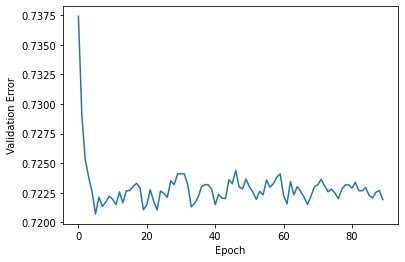

In [41]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

## 세개의 잠재요인 가진 행렬 인수분해를 사용한 추천 시스템

In [42]:
n_latent_factors = 3

user_input = Input(shape=[1], name='user')

user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(10e-7), 
                           name='user_embedding')(user_input)

user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')

movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(10e-7), 
                            name='movie_embedding')(movie_input)

movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)

model = Model(inputs=[user_input, movie_input], outputs=product)

In [43]:
model.compile('adam', 'mean_squared_error')

In [44]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating,
                    epochs=100, 
                    validation_data=([X_validation.newUserId, 
                                      X_validation.newMovieId],
                                      X_validation.rating),
                    verbose=1)

Epoch 1/100
2563/2563 [==============================] - 8s 3ms/step - loss: 12.0046 - val_loss: 7.4526
Epoch 2/100
2563/2563 [==============================] - 6s 2ms/step - loss: 4.1416 - val_loss: 2.4087
Epoch 3/100
2563/2563 [==============================] - 7s 3ms/step - loss: 1.6532 - val_loss: 1.2541
Epoch 4/100
2563/2563 [==============================] - 8s 3ms/step - loss: 1.0127 - val_loss: 0.9045
Epoch 5/100
2563/2563 [==============================] - 9s 3ms/step - loss: 0.8159 - val_loss: 0.7928
Epoch 6/100
2563/2563 [==============================] - 6s 3ms/step - loss: 0.7530 - val_loss: 0.7489
Epoch 7/100
2563/2563 [==============================] - 6s 2ms/step - loss: 0.7325 - val_loss: 0.7384
Epoch 8/100
2563/2563 [==============================] - 7s 3ms/step - loss: 0.7249 - val_loss: 0.7326
Epoch 9/100
2563/2563 [==============================] - 6s 2ms/step - loss: 0.7225 - val_loss: 0.7297
Epoch 10/100
2563/2563 [==============================] - 7s 3ms/step - 

Minimum MSE:  0.6843380928039551


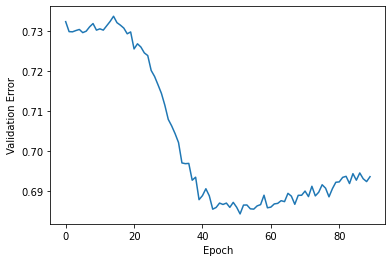

In [45]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

## 다섯개의 잠재요인 가진 행렬 인수분해를 사용한 추천 사스템

In [46]:
n_latent_factors = 5

user_input = Input(shape=[1], name='user')

user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(10e-7), 
                           name='user_embedding')(user_input)

user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')

movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(10e-7), 
                            name='movie_embedding')(movie_input)

movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)

model = Model(inputs=[user_input, movie_input], outputs=product)

In [47]:
model.compile('adam', 'mean_squared_error')

In [48]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId],
                    y=X_train.rating,
                    epochs=100, 
                    validation_data=([X_validation.newUserId, 
                                      X_validation.newMovieId],
                                      X_validation.rating), 
                    verbose=1)

Epoch 1/100
2563/2563 [==============================] - 9s 3ms/step - loss: 11.1079 - val_loss: 5.3200
Epoch 2/100
2563/2563 [==============================] - 8s 3ms/step - loss: 2.7706 - val_loss: 1.6059
Epoch 3/100
2563/2563 [==============================] - 8s 3ms/step - loss: 1.1582 - val_loss: 0.9442
Epoch 4/100
2563/2563 [==============================] - 8s 3ms/step - loss: 0.8303 - val_loss: 0.7934
Epoch 5/100
2563/2563 [==============================] - 9s 4ms/step - loss: 0.7536 - val_loss: 0.7497
Epoch 6/100
2563/2563 [==============================] - 7s 3ms/step - loss: 0.7348 - val_loss: 0.7383
Epoch 7/100
2563/2563 [==============================] - 8s 3ms/step - loss: 0.7288 - val_loss: 0.7400
Epoch 8/100
2563/2563 [==============================] - 6s 2ms/step - loss: 0.7275 - val_loss: 0.7362
Epoch 9/100
2563/2563 [==============================] - 6s 2ms/step - loss: 0.7265 - val_loss: 0.7331
Epoch 10/100
2563/2563 [==============================] - 6s 2ms/step - 

Minimum MSE:  0.676782488822937


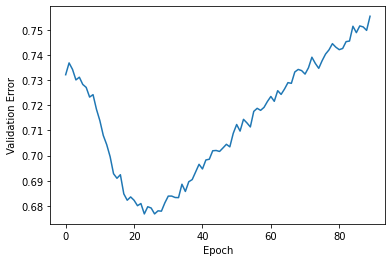

In [49]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))